In [5]:
import pyopenms as oms
import pandas as pd
import sys
sys.path.append(r"..")
import microspot_reader as msu
import matplotlib.pyplot as plt
import microspot_reader.plots as plots
from matplotlib import colors
import numpy as np
%matplotlib widget

In [6]:
mzmlfilename="../test_mzml/231004_TestAB_1.mzML"

exp = oms.MSExperiment()
oms.MzMLFile().load(mzmlfilename, exp)

fm=msu.feature_finding(
    exp=exp,
    filename=mzmlfilename,
    mass_error=10,
    noise_threshold=1e5,
    min_fwhm=1,
    max_fwhm=60
)

msu.ms2_mapping(
    exp=exp,
    fm=fm
)

ft,consensus_map=msu.adduct_detector(
    fm=fm,
    adduct_list=[
        b'H:+:0.4', 
        b'Na:+:0.2', 
        b'NH4:+:0.2', 
        b'H3O1:+:0.1', 
        b'CH2O2:+:0.1', 
        b"H-2O-1:0:0.2"
    ]
)

xics,spectra=msu.xic_generator(
    exp=exp,
    ft=ft
)

ft

Progress of 'mass trace detection':
-- done [took 7.97 s (CPU), 8.58 s (Wall)] -- 
Progress of 'elution peak detection':
-- done [took 0.44 s (CPU), 0.06 s (Wall)] -- 
Progress of 'assembling mass traces to features':
-- done [took 0.31 s (CPU), 0.04 s (Wall)] -- 
Unassigned peptides: 0
Peptides assigned to exactly one feature: 0
Peptides assigned to multiple features: 0
Unassigned and unidentified precursors: 2154
Unidentified precursor assigned to exactly one feature: 0
Unidentified precursor assigned to multiple features: 0
Feature annotation with identifications:
    no ID: 134
    single ID: 0
    multiple IDs (identical): 0
    multiple IDs (divergent): 0


Adding neutral: ---------- Adduct -----------------
Charge: 0
Amount: 1
MassSingle: -18.0106
Formula: H-2O-1
log P: -1.60944

MassExplainer table size: 938
Generating Masses with threshold: -6.90776 ...
done
46 of 698 valid net charge compomer results did not pass the feature charge constraints
Inferring edges raised edge coun

,charge,RT,mz,RTstart,RTend,MZstart,MZend,quality,intensity,adduct
feature_id,,,,,,,,,,
4434920204712248944,3,66.709224,388.468027,64.374726,85.729362,388.465607,389.138245,0.000443,24186778.0,H3
3591487352946394154,3,67.913730,150.768212,64.942854,85.729362,150.768082,151.102859,0.000309,24854486.0,H3
4449655127439253683,2,67.913730,306.684185,64.942854,86.747238,306.683350,307.186554,0.000353,25665592.0,H2
17656561466341703412,2,67.913730,391.132227,65.570604,84.818988,391.130951,391.635071,0.000167,10729629.0,H2
8527786824367363522,3,68.554974,160.112047,63.663474,87.363738,160.112000,160.781265,0.001772,143574000.0,H3
...,...,...,...,...,...,...,...,...,...,...
1824169827924148287,1,241.742562,494.130137,239.490684,281.990580,494.128357,495.133667,0.000543,40091324.0,H1
12685016132740778265,1,241.742562,965.408884,236.065812,274.571826,965.406616,966.413513,0.000721,37795088.0,H1
9973349792534296857,1,243.879312,204.135465,74.719104,275.160582,204.134781,205.140030,0.000175,15587993.0,H1


In [7]:
filtered_map=oms.ConsensusMap(consensus_map)
filtered_map.clear(False)
for feature in consensus_map:
    if feature.getPeptideIdentifications():
        filtered_map.push_back(feature)

consensusXML_file = "filtered.consensusXML"
oms.ConsensusXMLFile().store(consensusXML_file, filtered_map)

# for FFBM
oms.GNPSMGFFile().store(
    oms.String(consensusXML_file),
    [mzmlfilename.encode()],
    oms.String("MS2data.mgf"),
)
oms.GNPSQuantificationFile().store(consensus_map, "FeatureQuantificationTable.txt")


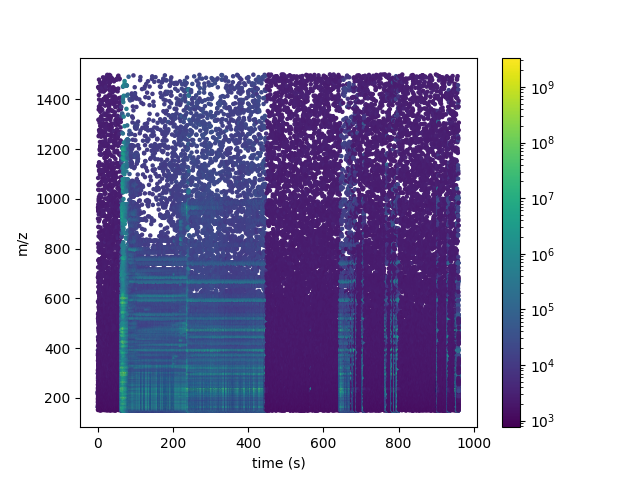

In [8]:
def plot_spectra_2D(exp, ms_level=1, marker_size=5):
    exp.updateRanges()
    for spec in exp:
        if spec.getMSLevel() == ms_level:
            mz, intensity = spec.get_peaks()
            p = intensity.argsort()  # sort by intensity to plot highest on top
            rt = np.full([mz.shape[0]], spec.getRT(), float)
            plt.scatter(
                rt,
                mz[p],
                c=intensity[p],
                cmap="viridis",
                s=marker_size,
                norm=colors.LogNorm(
                    exp.getMinIntensity() + 1, exp.getMaxIntensity()
                ),
            )
    plt.clim(exp.getMinIntensity() + 1, exp.getMaxIntensity())
    plt.xlabel("time (s)")
    plt.ylabel("m/z")
    plt.colorbar()
    plt.show()  # slow for larger data sets

plot_spectra_2D(exp)

,peak_idx,RT,start_idx,end_idx,RTstart,RTend,max_int,AUC
peak_nr,,,,,,,,
0,7,68.0,2,12,63.0,73.0,1.338950,7.175401
1,178,239.0,175,179,236.0,240.0,0.044267,0.093907


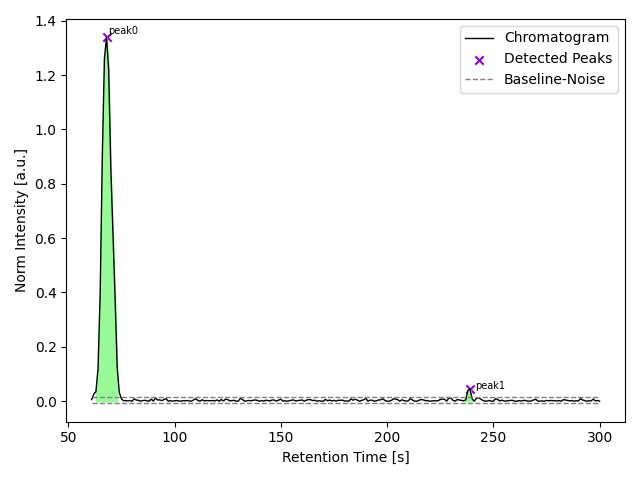

In [40]:
at=pd.read_csv("../output/output_concat.csv",index_col=0)
at.sort_values("RT",inplace=True)

aft=msu.peak_detection(
    df=at,
    baseline_convergence=0.02,
    rel_height=0.95,
    min_dist=10,
    datacolumn_name="norm_intensity"
)

fig,ax=plt.subplots()
plots.plot_activity_chromatogram(
    figure=fig,
    axs=ax,
    spot_df=at,
    peak_df=aft,
    baseline_acceptance=0.02,
    ydata_name="norm_intensity"
)

aft

In [42]:
msu.activity_annotation_features(
    ft=ft,
    aft=aft,
    act_df=at,
    xic_dict=xics,
    rt_tolerance=10,
    ydata_name="norm_intensity"
    )

ft.sort_values("pearson_corr_peak0",ascending=False,inplace=True)

ft.head(10)

ft.to_csv("test.csv")

ft


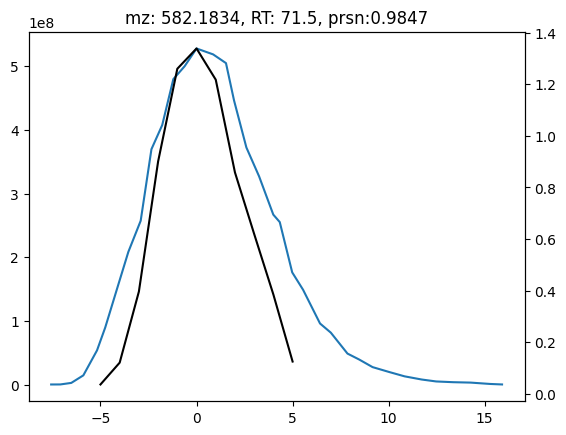

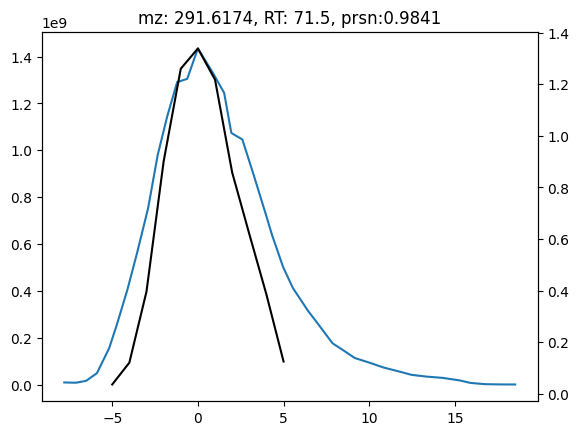

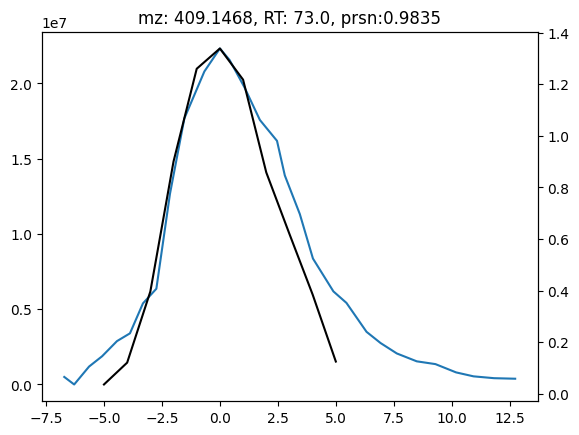

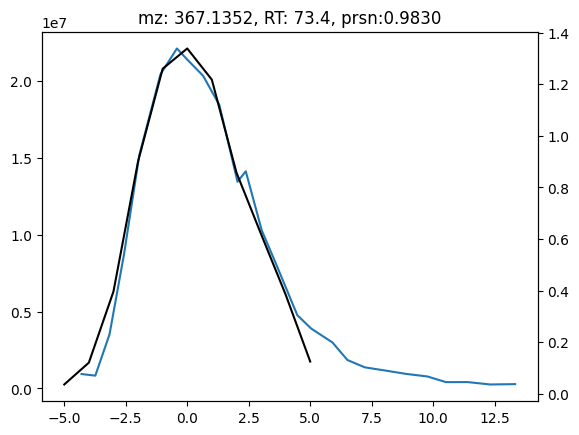

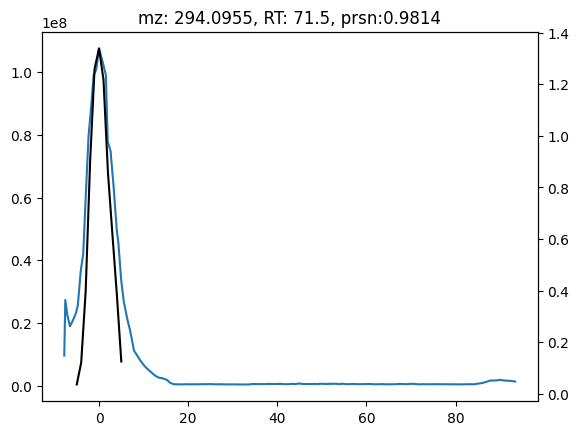

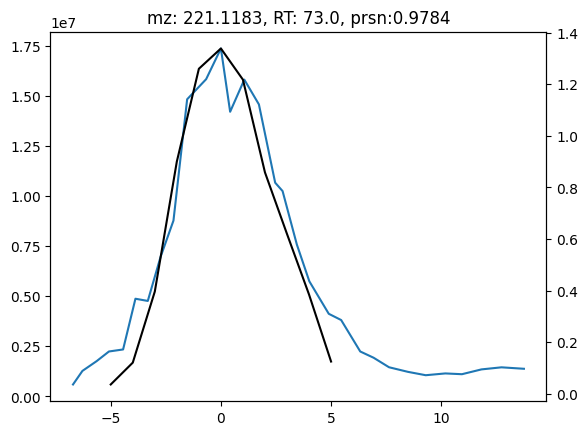

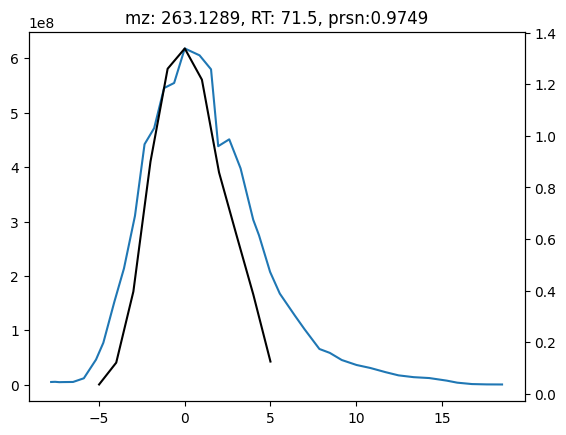

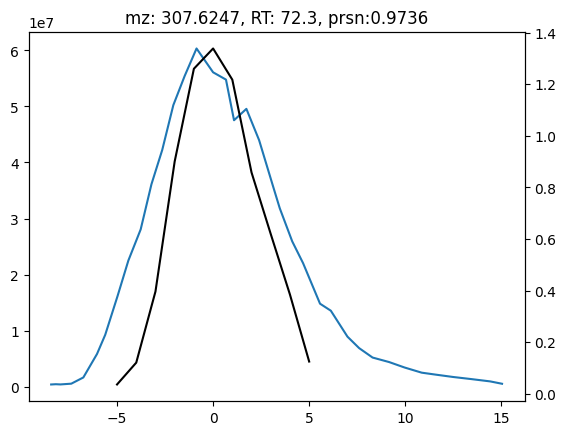

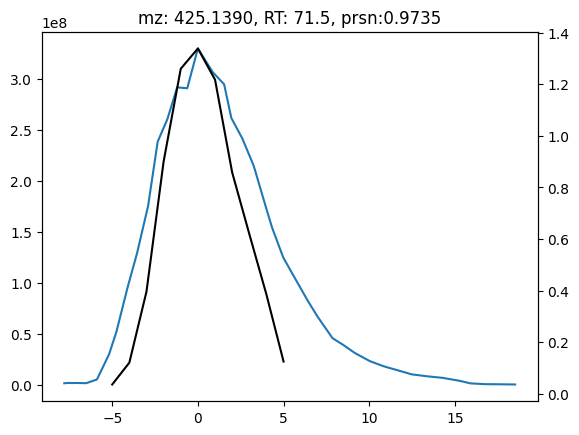

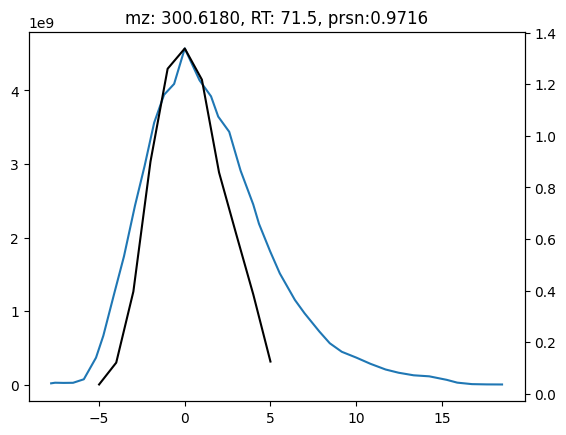

In [21]:
for i in ft.loc[ft["pearson_corr_peak0"]>0].index:
    df=xics[i]
    fig,ax=plt.subplots()
    ax.plot(df.rt-ft.loc[i,"RT"],df.int)
    ax2=ax.twinx()
    ax2.plot(at.loc[aft.loc[0,"left_ips"]:aft.loc[0,"right_ips"],"RT"]-aft.loc[0,"RT"],at.loc[aft.loc[0,"left_ips"]:aft.loc[0,"right_ips"],"norm_intensity"],c="k")

    ax.set(title=f"mz: {ft.loc[i,'mz']:.4f}, RT: {ft.loc[i,'RT']:.1f}, prsn:{ft.loc[i,'pearson_corr_peak0']:.4f}")
